# Multivariate Linear Regression

### Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets

### Let's Start With The Math!

##### Multivariate linear regression function
$$f_{\vec{w},b}(\vec{x})=\vec{w}\cdot\vec{x}+b$$

In [2]:
def lin_reg_func(X, w, b):
    """Linear regression function.

        Parameters:
            X (ndarray): mxn matrix of n features and m samples
            w (ndarray): vector of n weight parameters
            b (float): bias parameter
        
        Returns:
            ndarray: output of linear regression function for each sample
    """
    return (X @ w) + b

##### Cost function: Mean Squared Error (MSE)
$$J(\vec{w},b)=\frac{1}{2m}\sum_{i=1}^m(f_{\vec{w},b}(\vec{x}^{(i)})-y^{(i)})^2$$

In [3]:
def compute_cost(y_hat, y):
    """Mean squared error (MSE) cost function.

        Parameters:
            y_hat (ndarray): vector of m predictions
            y (ndarray): vector of m target values
        
        Returns:
            float: output of MSE cost function
    """
    m = len(y_hat)
    return (1 / (2 * m)) * np.sum((y_hat - y)**2)

##### Gradients
$$\frac{\partial}{\partial\vec{w}}J(\vec{w},b)=\frac{1}{m}\sum_{i=1}^m(f_{\vec{w},b}(\vec{x}^{(i)})-y^{(i)})\vec{x}^{(i)}$$
$$\frac{\partial}{\partial b}J(\vec{w},b)=\frac{1}{m}\sum_{i=1}^m(f_{\vec{w},b}(\vec{x}^{(i)})-y^{(i)})$$

In [4]:
def compute_gradients(X, y, y_hat):
    """Gradients, or derivative of cost function with respect to each parameter.

        Parameters:
            X (ndarray): mxn matrix of n features and m samples
            y (ndarray): vector of m target values
            y_hat (ndarray): vector of m predictions

        Returns:
            tuple containing

            - ndarray: n gradients with respect to each w
            - float: gradient with respect to b
    """
    m = X.shape[0]
    dj_dw = (1 / m) * ((y_hat - y) @ X)
    dj_db = (1 / m) * np.sum(y_hat - y)
    return dj_dw, dj_db

##### Gradient descent updates
$$\vec{w}=\vec{w}-\alpha\frac{\partial}{\partial\vec{w}}J(\vec{w},b)$$
$$b=b-\alpha\frac{\partial}{\partial b}J(\vec{w},b)$$

In [5]:
def update_param(param, alpha, gradient):
    """Update parameter step.

        Parameters:
            param (ndarray/float): either vector of n weight parameters or bias parameter to update
            alpha (float): learning rate
            gradient (ndarray/float): either n gradients with respect to w or gradient with respect to b

        Returns:
            ndarray/float: either vector of n weight parameters or bias parameter after update
    """
    return param - (alpha * gradient)

### California Housing Dataset

In [6]:
housing_dataset = datasets.fetch_california_housing(as_frame=True)
X = housing_dataset['data'].to_numpy()
y = housing_dataset['target'].to_numpy()
housing_df = housing_dataset['frame']
print(housing_dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

### Visualize And Clean Dataset

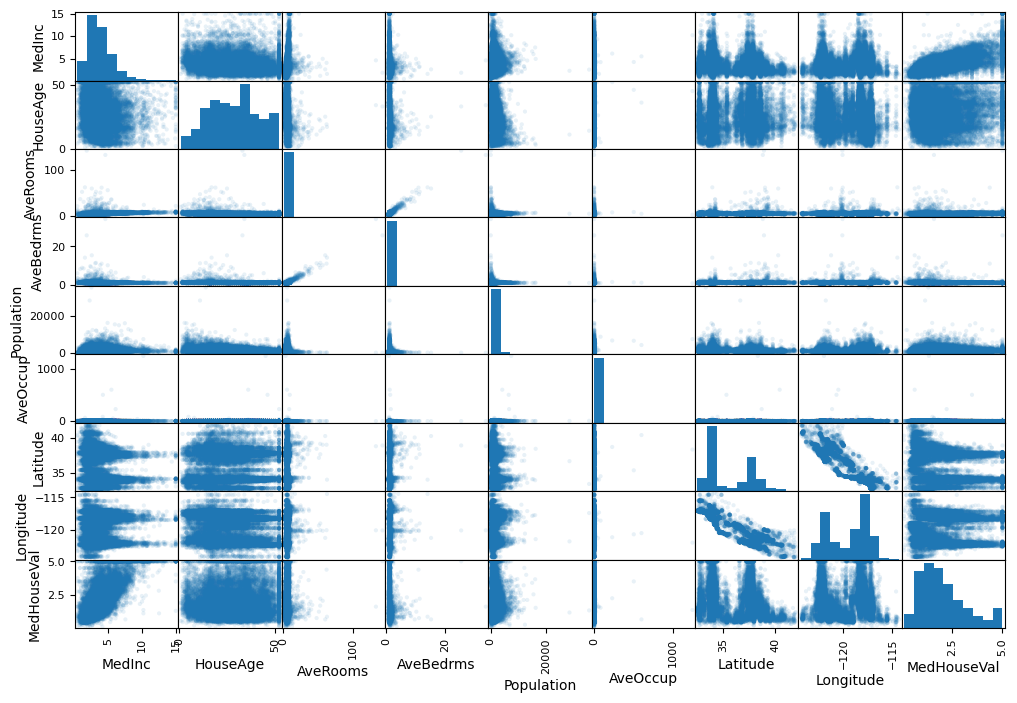

In [7]:
pd.plotting.scatter_matrix(housing_df, figsize=(12, 8), alpha=0.1)
plt.show()

In addition to the data quirks in MedHouseVal we found in the univariate linear regression notebook, there seems to be a cap on the HouseAge and MedInc features too. Let's clean this up.

In [8]:
# Get list of y values that appear at least 25 times in the dataset
y_values, counts = np.unique(y, return_counts=True)
y_frequent_values = y_values[np.where(counts >= 25)]

# Get indices of frequent y values or max house age values or max income values
bad_indices = np.where(np.isin(y, y_frequent_values) | (X[:, 0] == X[:, 0].max()) | (X[:, 1] == X[:, 1].max()))

# Remove all data points at each of the frequent y values and/or each of the max house age values and max income values
X_clean = np.delete(X, bad_indices, axis=0)
y_clean = np.delete(y, bad_indices)

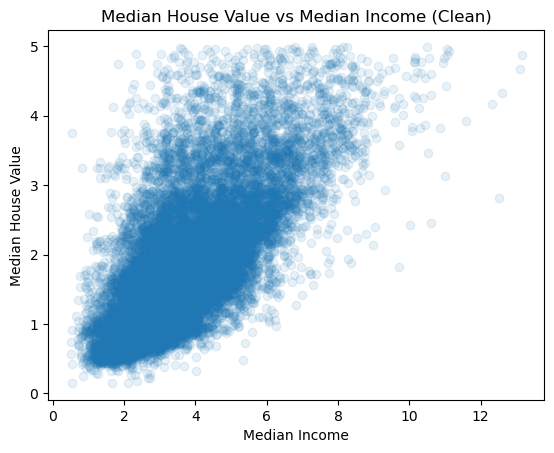

In [9]:
plt.scatter(X_clean[:, 0], y_clean, alpha=0.1)
plt.title('Median House Value vs Median Income (Clean)')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.show()

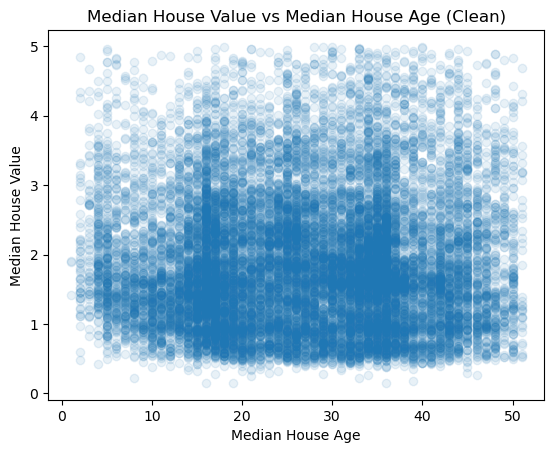

In [10]:
plt.scatter(X_clean[:, 1], y_clean, alpha=0.1)
plt.title('Median House Value vs Median House Age (Clean)')
plt.xlabel('Median House Age')
plt.ylabel('Median House Value')
plt.show()

### Split Dataset Into Training/Test Sets

In [11]:
def train_test_split(X, y, test_proportion=0.2):
    """Splits dataset into training set and test set.

        Parameters:
            X (ndarray): mxn matrix of n features and m samples
            y (ndarray): vector of m target values
            test_proportion (float): proportion of dataset to set to test set (default to 0.2)

        Returns:
            tuple containing
            
            - ndarray: (m * 0.8)xn matrix of training set feature values
            - ndarray: vector of (m * 0.8) training set target values
            - ndarray: (m * 0.2)xn matrix of test set feature values
            - ndarray: vector of (m * 0.2) test set target values
    """
    random_indices = np.random.permutation(X.shape[0])
    test_size = round(test_proportion * X.shape[0])
    test_indices = random_indices[:test_size]
    train_indices = random_indices[test_size:]

    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_test = X[test_indices, :]
    y_test = y[test_indices]

    return X_train, y_train, X_test, y_test

In [12]:
X_train, y_train, X_test, y_test = train_test_split(X_clean, y_clean)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (13662, 8)
y_train shape: (13662,)


### z-score Normalization

Each feature has a very different range of values. Let's use z-score normalization to normalize our training data.
$$x_j=\frac{x_j-\mu_j}{\sigma_j}$$

Standard deviation formula:
$$\sigma_j=\sqrt{\frac{\sum_{i=1}^m(x_j^{(i)}-\mu_j)^2}{m}}$$

In [13]:
def compute_std(X, mu):
    """Standard deviation of each feature.

        Parameters:
            X (ndarray): mxn matrix of n features and m samples
            mu (ndarray): mean of each of the n features
        
        Returns:
            ndarray: standard deviation of each of the n features
    """
    return np.sqrt(np.sum((X - mu)**2, axis=0) / X.shape[0])

In [14]:
X_train_mu = np.mean(X_train, axis=0)
X_train_std = compute_std(X_train, X_train_mu)
X_train_normalized = (X_train - X_train_mu) / X_train_std

# Normalize the test set too, but using the mean and standard deviation of the training set
X_test_normalized = (X_test - X_train_mu) / X_train_std

### Training

First we set the *hyperparameters* to configure our training process, and then we train on the training set.

In [15]:
def gradient_descent(X, y, w, b, alpha, num_epochs):
    """Gradient descent training process.
    
        Parameters:
            X (ndarray): mxn matrix of training set feature values
            y (ndarray): vector of m training set target values
            w (ndarray): vector of n initial weight parameter values
            b (float): initial bias parameter value
            alpha (float): learning rate
            num_epochs (int): number of epochs to execute

        Returns:
            tuple containing

            - ndarray: vector of n learned weight parameters
            - float: learned bias parameter
            - list[float]: log of costs after each epoch
    """
    cost_log = []

    for epoch in range(num_epochs):
        # Predict
        y_hat = lin_reg_func(X, w, b)

        # Compute Cost
        cost = compute_cost(y_hat, y)
        cost_log.append(cost)

        # Train
        dj_dw, dj_db = compute_gradients(X, y, y_hat)
        w = update_param(w, alpha, dj_dw)
        b = update_param(b, alpha, dj_db)

        print(f'Epoch: {epoch + 1} | Cost: {cost}')
    
    return w, b, cost_log

In [16]:
w, b, cost_log = gradient_descent(
    X_train_normalized, y_train,
    w=np.zeros(X_train_normalized.shape[1]), b=0.0,
    alpha=0.005,
    num_epochs=1000
)

Epoch: 1 | Cost: 2.261537884240964
Epoch: 2 | Cost: 2.2409772260297998
Epoch: 3 | Cost: 2.2206253514065497
Epoch: 4 | Cost: 2.2004800993241793
Epoch: 5 | Cost: 2.1805393317298325
Epoch: 6 | Cost: 2.1608009333092775
Epoch: 7 | Cost: 2.1412628112343803
Epoch: 8 | Cost: 2.1219228949135718
Epoch: 9 | Cost: 2.102779135745264
Epoch: 10 | Cost: 2.0838295068741846
Epoch: 11 | Cost: 2.06507200295058
Epoch: 12 | Cost: 2.0465046398922704
Epoch: 13 | Cost: 2.0281254546494982
Epoch: 14 | Cost: 2.009932504972543
Epoch: 15 | Cost: 1.9919238691820802
Epoch: 16 | Cost: 1.9740976459422215
Epoch: 17 | Cost: 1.9564519540362313
Epoch: 18 | Cost: 1.9389849321448607
Epoch: 19 | Cost: 1.9216947386272862
Epoch: 20 | Cost: 1.904579551304604
Epoch: 21 | Cost: 1.887637567245857
Epoch: 22 | Cost: 1.8708670025565592
Epoch: 23 | Cost: 1.8542660921696867
Epoch: 24 | Cost: 1.8378330896390995
Epoch: 25 | Cost: 1.8215662669353756
Epoch: 26 | Cost: 1.8054639142440092
Epoch: 27 | Cost: 1.78952433976596
Epoch: 28 | Cost: 1

### Assess Results

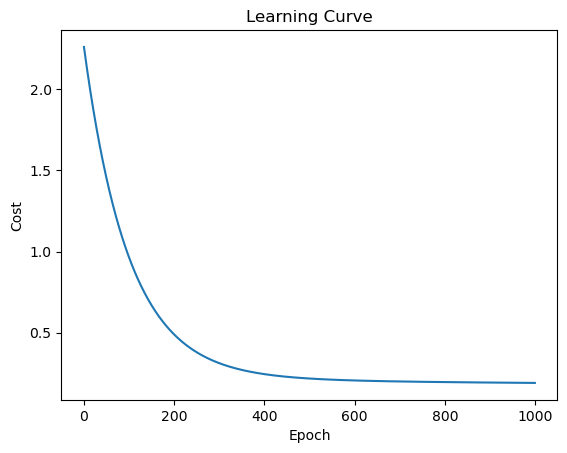

In [17]:
plt.plot(cost_log)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

In [18]:
y_hat = lin_reg_func(X_test_normalized, w, b)
test_cost = compute_cost(y_hat, y_test)

print(f'Cost on training set: {cost_log[-1]}')
print(f'Cost on test set: {test_cost}')

Cost on training set: 0.19031395884271582
Cost on test set: 0.19221541174448922


See! Much better than only using one feature.